In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import spacy
from spacy.tokens import Token
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import gutenberg, stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

In [2]:
# Utility function for standard text cleaning
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'. 
    text = re.sub(r'--',' ',text)
    # get rid of text between brackets
    text = re.sub("[\[].*?[\]]", "", text)
    
    # Get rid of extra whitespace
    text = ' '.join(text.split())
    return text

In [3]:
milton = gutenberg.raw('milton-paradise.txt')
chesterton = gutenberg.raw('chesterton-brown.txt')

# Chapters are book specific
# Need to clear chapters before runnign clean text
chesterton = re.sub('[IVX][IVX]*\. *The.*', '', chesterton)
milton = re.sub(r'Book .*', '', milton)

milton_clean = text_cleaner(milton)
chesterton_clean = text_cleaner(chesterton)


In [4]:
# Parse the cleaned novels. 
nlp = spacy.load('en')
chesterton_doc = nlp(chesterton_clean)
milton_doc = nlp(milton_clean)



In [ ]:
# Parse the cleaned novels. 
chesterton_doc = nlp(chesterton_clean)
milton_doc = nlp(milton_clean)


In [46]:
# Group into sentences
chesterton_sents = [[sent, 'Chesterton'] for sent in chesterton_doc.sents]
milton_sents = [[sent, 'Milton'] for sent in milton_doc.sents]

# Combine the setnences from the two novels into one data frame
sentences = pd.DataFrame(chesterton_sents + milton_sents)
sentences.columns = ['text_sentences', 'author']
sentences.head()

both_sents = [' '.join([token.lemma_ for token in sent]) for sent in sentences['text_sentences']]


In [48]:
both_sents[0:5]

['the consulting - room of dr orion hood , the eminent criminologist and specialist in certain moral disorder , lie along the sea - front at scarborough , in a series of very large and well - light french window , which show the north sea like one endless outer wall of blue - green marble .',
 'in such a place the sea have something of the monotony of a blue - green dado : for the chamber -PRON- be rule throughout by a terrible tidiness not unlike the terrible tidiness of the sea .',
 "-PRON- must not be suppose that dr hood 's apartment exclude luxury , or even poetry .",
 'these thing be there , in -PRON- place ; but one feel that -PRON- be never allow out of -PRON- place .',
 'luxury be there : there stand upon a special table eight or ten box of the good cigar ; but -PRON- be build upon a plan so that the strong be always nearest the wall and the mildest nearest the window .']

In [10]:
# Add function to make stop words case insensitive
stop_words_getter = lambda token: token.is_stop or token.lower_ in STOP_WORDS 
Token.set_extension('is_stop', getter=stop_words_getter)

In [22]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token._.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token._.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [16]:
# Set up the bags.
milton_words = bag_of_words(milton_doc)
chesterton_words = bag_of_words(chesterton_doc)

# Combine bags to create a set of unique words.
common_words = set(milton_words + chesterton_words)

In [24]:
# Create our data frame with features. This can take a while to run.
#word_counts = bow_features(sentences, common_words)
#word_counts.head()
#word_counts.to_csv('word_counts_p5.csv')

In [42]:
def sentence_words(example_sentence):
    return [token for token in example_sentence if not token.is_punct]

In [43]:
sentences['words'] = sentences['text_sentences'].apply(sentence_words)

In [67]:
vectorizer = CountVectorizer(max_features=2000, min_df=10, stop_words=STOP_WORDS)
X = vectorizer.fit_transform(both_sents)
print(vectorizer.get_feature_names())
print(X.toarray())  


['able', 'abruptly', 'absence', 'absent', 'abyss', 'accept', 'accord', 'account', 'accuse', 'achieve', 'act', 'action', 'actor', 'adam', 'add', 'address', 'admiral', 'admiration', 'admire', 'admit', 'adore', 'adorn', 'advance', 'advanced', 'advantage', 'advise', 'affair', 'afraid', 'age', 'ago', 'aid', 'air', 'alike', 'alive', 'allow', 'almighty', 'aloud', 'altar', 'alter', 'ambition', 'american', 'amid', 'amidst', 'ancient', 'angel', 'angelick', 'angels', 'anger', 'anon', 'answer', 'anybody', 'appear', 'appearance', 'appease', 'appetite', 'approach', 'arch', 'argue', 'arise', 'ark', 'arm', 'armagnac', 'armed', 'army', 'array', 'arrive', 'art', 'arthur', 'ascend', 'ask', 'aspect', 'aspire', 'assault', 'assent', 'assume', 'assure', 'astonishment', 'attain', 'attempt', 'attend', 'attention', 'audience', 'aught', 'aurora', 'author', 'away', 'awful', 'bad', 'bald', 'band', 'bank', 'banker', 'bar', 'bare', 'battle', 'beam', 'bear', 'beard', 'beast', 'beauty', 'bed', 'befall', 'begin', 'behe

In [68]:
X

<6465x1429 sparse matrix of type '<class 'numpy.int64'>'
	with 50961 stored elements in Compressed Sparse Row format>

# Random Forest Classifier

In [66]:
rfc = RandomForestClassifier(n_estimators=10)
Y = sentences['author']
X_array = X.toarray()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=0.4, 
                                                    random_state=0)

train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9902036607373035

Test set score: 0.8731631863882444


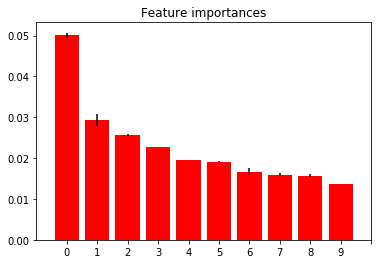

In [85]:
importances = rfc.feature_importances_
importances = -np.sort(-importances)[:10]
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, 10])
plt.show()

# TF-IDF

In [86]:
X_train, X_test = train_test_split(sentences, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
sents_tfidf=vectorizer.fit_transform(sentences[0])
print("Number of features: %d" % sents_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(sents_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

KeyError: 0